# Importing required libraries

In [1]:
#@title Installing required libraries
!pip install -q wordcloud transformers torch==2.1.0 accelerate>=0.20.1 transformers[torch] fastapi uvicorn nest-asyncio pyngrok nltk

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
tensorflow-probability 0.22.0 requires typing-extensions<4.6.0, but you have typing-extensions 4.9.0 which is incompatible.


In [2]:
#@title Importing libraries
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import os
import torch
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

TRAIN_TEXT_COLUMN = "tweet_text"
TRAIN_SENTIMENT_COLUMN = "sentiment"
TEST_TEXT_COLUMN = "Tweet"
TEST_SENTIMENT_COLUMN = "sentiment"

DATA_DIR = "/content/drive/MyDrive/MyProjects/sentiment-analysis"
data_path = f"{DATA_DIR}/twitter_sentiment_dataset.xlsx"

## Training parameters
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
OUTPUT_DIR_NAME = f"{DATA_DIR}/output"
NUM_TRAIN_EPOCHS = 30
PER_DEVICE_TRAIN_BATCH_SIZE = 80
PER_DEVICE_EVAL_BATCH_SIZE = 80
LOGGING_STEPS = 500
SAVE_STEPS = 1000

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Reading the Dataset

In [3]:
#@title Read Dataset

xl = pd.ExcelFile(data_path)

training_data = xl.parse("Train")
testing_set = xl.parse("Test")

training_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [14]:
#@title Transforming the dataset

renamed_emotions = {"Negative emotion": "NEGATIVE", "Positive emotion": "POSITIVE", "No emotion toward brand or product": "NEUTRAL", "I can't tell": "Not Sure"}
renamed_columns = {"emotion_in_tweet_is_directed_at": "emotion_towards", "is_there_an_emotion_directed_at_a_brand_or_product": TRAIN_SENTIMENT_COLUMN}
training_set = training_data.rename(columns=renamed_columns)
training_set.loc[training_set[TRAIN_SENTIMENT_COLUMN] == "Negative emotion", TRAIN_SENTIMENT_COLUMN] = renamed_emotions["Negative emotion"]
training_set.loc[training_set[TRAIN_SENTIMENT_COLUMN] == "Positive emotion", TRAIN_SENTIMENT_COLUMN] = renamed_emotions["Positive emotion"]
training_set.loc[training_set[TRAIN_SENTIMENT_COLUMN] == "No emotion toward brand or product", TRAIN_SENTIMENT_COLUMN] = renamed_emotions["No emotion toward brand or product"]
training_set.loc[training_set[TRAIN_SENTIMENT_COLUMN] == "I can't tell", TRAIN_SENTIMENT_COLUMN] = renamed_emotions["I can't tell"]

training_set = training_set[[TRAIN_TEXT_COLUMN, TRAIN_SENTIMENT_COLUMN]].copy()
training_set.drop_duplicates(inplace=True)
training_set.dropna(inplace=True)
training_set.sample(10)

,tweet_text,sentiment
6192,RT @mention RT @mention Google to Launch Major...,NEUTRAL
7627,LOL!! Classic! RT @mention This Google/Bing Q&...,NEUTRAL
7428,Mindjet is going to #SXSW and to celebrate we ...,NEUTRAL
463,"Before It Even Begins, Apple Wins SXSW: {link}...",POSITIVE
6196,RT @mention RT @mention Heading to Austin for ...,NEUTRAL
223,Spent the aftrnoon on a frozen lake photograph...,NEUTRAL
8191,I just found BBQ sauce on my iPad - tech and T...,POSITIVE
1408,no no no... my bad its lady XD {link} #sxsw iP...,NEUTRAL
5735,RT @mention I'd pay an iPad 2 to the person wh...,POSITIVE
5276,RT @mention Calvin is now the Geek Charlie She...,NEUTRAL


In [5]:
#@title Converting sentiment strings into integer labels

le = LabelEncoder()

## Avoid providing 'Not Sure' sentiments for training
training_set = training_set[training_set[TRAIN_SENTIMENT_COLUMN]!="Not Sure"][[TRAIN_TEXT_COLUMN, TRAIN_SENTIMENT_COLUMN]]
training_set.dropna(inplace=True)
training_set[TRAIN_TEXT_COLUMN] = training_set[TRAIN_TEXT_COLUMN].astype(str)
training_set["sentiment_str"] = training_set[TRAIN_SENTIMENT_COLUMN]
training_set[TRAIN_SENTIMENT_COLUMN] = le.fit_transform(training_set[TRAIN_SENTIMENT_COLUMN])

# Cleaning The Dataset

In [6]:
#@title Text Cleaner Class

class TextCleaner:
    """Class to clean words and sentences"""

    def __init__(
        self,
        use_lemmatizer: bool = False,
    ):
        """initializes the lemmatizer model from spacy"""
        if use_lemmatizer:
            spacy_download_command = "pip install spacy && python -m spacy download en_core_web_sm"
            import os

            os.system(spacy_download_command)
            import spacy

            self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    def lemmatize_word(self, word: str) -> str:
        """Method to lemmatize a word

        Args:
            word (str): Original/Unclean version of the word

        Returns:
            str: Lemmatized word
        """
        return [token.lemma_ for token in self.nlp(word)][0]  # find lemma of the word

    def word_eliminator(self, text):
        non_ascii_pattern = re.compile(r'[^\x00-\x7F]+')
        text = non_ascii_pattern.sub('', text)

        # Remove words starting with '@' or '#'
        text = re.sub(r'\B[@#]\w+', '', text)

        # Remove URLs starting with 'http' or 'www'
        text = re.sub(r'http\S+|www\.\S+', '', text)

        return text

    def clean_sentences(
        self,
        og_sentences: list,
        more_stops: list = list(),
        lemmatize: bool = False,
    ) -> tuple:
        stops = stopwords.words("english")
        stops.extend(more_stops) if more_stops else None

        cleaning_phase = [
            str(re.sub(" +", " ", sentence)).strip() for sentence in og_sentences
        ]
        cleaining_phase = [self.word_eliminator(sentence) for sentence in cleaning_phase]
        cleaning_phase = [
            sentence.translate(
                str.maketrans(string.punctuation, " " * len(string.punctuation))
            )
            for sentence in cleaning_phase
        ]
        cleaning_phase = [
            re.sub("(\r\n)|[0-9]", "", sentence) for sentence in cleaning_phase
        ]
        cleaning_phase = [
            sentence.replace("®", "").replace("", "").replace("Ã", "").lower()
            for sentence in cleaning_phase
        ]
        cleaning_phase = [
            str(re.sub(" +", " ", sentence)).strip() for sentence in cleaning_phase
        ]
        useful_sentences = []
        useful_words = []

        for sentence, og_sent, index in zip(
            cleaning_phase, og_sentences, range(len(og_sentences))
        ):
            words = []
            for word in sentence.split():
                if word not in stops:
                    if lemmatize == True:
                        word = self.lemmatize_word(word)
                    if word not in words:
                        words.append(word.strip())

            sentence = " ".join(words)

            if sentence not in useful_sentences and words not in useful_words:
                useful_sentences.append(sentence)
                useful_words.extend(words)

        useful_sentences = [text for text in useful_sentences if text]

        return useful_sentences, useful_words

In [7]:
#@title Cleaning `TRAIN_TEXT_COLUMN`

cleaner = TextCleaner()
training_set[TRAIN_TEXT_COLUMN] = training_set[TRAIN_TEXT_COLUMN].apply(lambda text: cleaner.clean_sentences([text])[0][0])
training_set.sample(10)

,tweet_text,sentiment,sentiment_str
1681,sxsw novelty ipad news apps fades fast among d...,0,NEGATIVE
6433,rt mention tomorrow charles chen speaking andr...,1,NEUTRAL
4256,hey vufinders awesome new update mention iphon...,2,POSITIVE
5522,rt mention google maps million users percent m...,1,NEUTRAL
6567,rt mention win ipad signing link sxsw wantlet,1,NEUTRAL
2101,marissa mayer taking phone location data ski h...,1,NEUTRAL
4197,left brain search google right x best session ...,2,POSITIVE
1529,mention new ubersocial iphone app store includ...,1,NEUTRAL
236,gsd amp google sitting tree link sxsw gsdm,1,NEUTRAL
3102,asked google chrome team ie feeback anything r...,1,NEUTRAL


In [8]:
import re

def remove_special_words_and_urls(text):
    # Remove words starting with '@' or '#'
    text = re.sub(r'\B[@#]\w+', '', text)

    # Remove URLs starting with 'http' or 'www'
    text = re.sub(r'http\S+|www\.\S+', '', text)

    return text

# Example usage
input_string = "Hello @world, this is a test #string. Visit https://www.example.com or got to www.j.com for more info. I want to remove @words starting #with these characters."
output_string = remove_special_words_and_urls(input_string)
print(output_string)

Hello , this is a test . Visit  or got to  for more info. I want to remove  starting  these characters.


# EDA: Training Set

In [9]:
#@title Total Number of Tweets

training_set[TRAIN_TEXT_COLUMN].shape[0]

8557

## Counts of Sentiments

<Axes: >

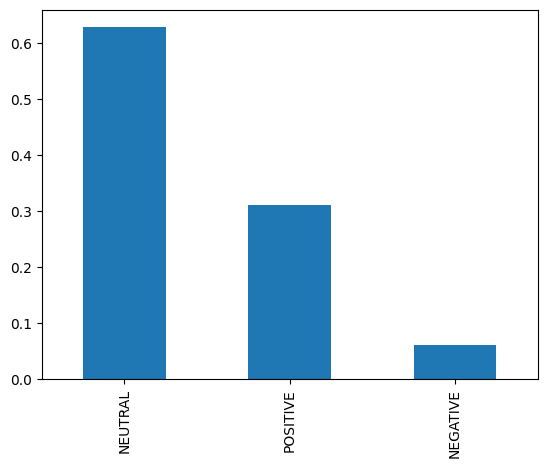

In [10]:
#@title Bar Plot for Counts of Sentiments
training_set.sentiment_str.value_counts(normalize=True).plot(kind='bar')

## Words with highest count in tweets

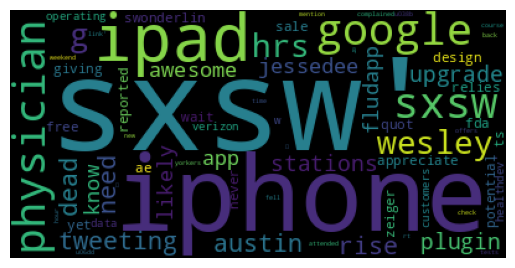

In [11]:
#@title Plotting words with highest count
text = training_set[TRAIN_TEXT_COLUMN].values
wordcloud = WordCloud(stopwords=set(STOPWORDS)).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Ways to Improve the given Dataset
- We can add more negative tweets to the dataset as its number is quite less compared to the rest of the tweet emotions.
- We should solve the tweets with sentiments like "I can't tell" to better train a machine learning model on the correct dataset.
- We should make the dataset as much balanced upon sentiments as we can for better training of a model.
- We should clean the tweet_text column by removing numbers, emoticons, CRLF characters, english stopwords, string punctuations, and special characters.

# Fine-Tune a Transformers Model

In [12]:
#@title Model Train Class
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def main(train_data, model_name, output_dir, num_train_epochs, per_device_train_batch_size, per_device_eval_batch_size, logging_steps, save_steps):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=3, ignore_mismatched_sizes=True).to(device)
    tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

    train_dataset = SentimentDataset(train_data[TRAIN_TEXT_COLUMN].to_numpy(), train_data[TRAIN_SENTIMENT_COLUMN].to_numpy(), tokenizer, max_length=128)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=output_dir,
        logging_steps=logging_steps,
        save_steps=save_steps,
        save_total_limit=2,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()
    trainer.save_model(output_dir)


In [13]:
#@title Train the model

train_data = training_set.copy()
print(f"Train Data Size: {train_data.shape[0]}")
test_data = testing_set[[TEST_TEXT_COLUMN]].copy()

main(train_data, MODEL_NAME, OUTPUT_DIR_NAME, NUM_TRAIN_EPOCHS, PER_DEVICE_TRAIN_BATCH_SIZE, PER_DEVICE_EVAL_BATCH_SIZE, LOGGING_STEPS, SAVE_STEPS)

Train Data Size: 8557


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.637200
1000,0.231100
1500,0.095600
2000,0.052300
2500,0.034900
3000,0.023300


# Model Evaluation

## Some common ways to evaluate a fine-tuned model
- #### Accuracy
- #### Precision-Recall Curve (for imbalanced datasets)
- #### Cross-validation
- #### ROC curve & AUC
- #### Per-class performance